<a href="https://colab.research.google.com/github/AbhinavRadhakrishnan/Machine-Learning-Projects/blob/main/Rice_Leaf_Diseases.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# PRCP-1001 Rice Leaf Disease Detection

In [ ]:
!pip install split-folder -q
#automatically split images into train/val/test.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
#Connects drive with colab

Mounted at /content/drive


In [49]:
#importing dependencies
import os
import glob
import random
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import shutil


In [ ]:
!pip install split-folders


In [ ]:
import splitfolders

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models, applications
from sklearn.metrics import confusion_matrix, classification_report


importing Dataset which is in Zip format

In [54]:
drive_path = "/content/drive/MyDrive/Datasets/PRCP-1001-RiceLeaf"


In [55]:
print("folder exists :", os.path.exists(drive_path)) #to check wheather the path is there or not


folder exists : True


copying dataset folder from drive to colab for faster access

In [60]:
local_dataset_dir = "/content/drive/MyDrive/Datasets/PRCP-1001-RiceLeaf"
#if the folder is not present in colab it will copy from drive and make local_dataset_dir
if not os.path.exists(local_dataset_dir):
    shutil.copytree(drive_path, local_dataset_dir)

In [61]:
# Set base_dir to the local copied folder
base_dir = local_dataset_dir
print("Base dir:", base_dir)
print("Classes:", os.listdir(base_dir))

Base dir: /content/drive/MyDrive/Datasets/PRCP-1001-RiceLeaf
Classes: ['Leaf smut', 'Bacterial leaf blight', 'Brown spot']


spliting dataset into Train , Test and Validation


In [63]:
output_dir = "/content/rice_splits"

splitfolders.ratio(
    base_dir,
    output=output_dir,
    seed=42, #every time you run the code, you get the same result.
    ratio=(0.7, 0.15, 0.15)
)


Copying files: 119 files [00:00, 149.92 files/s]


In [90]:

for split in ["train", "val", "test"]:
    data_folder = os.path.join(output_dir, split, "Data")
    if os.path.exists(data_folder):
        print("Removing extra folder:", data_folder)
        shutil.rmtree(data_folder)

Removing extra folder: /content/rice_splits/train/Data
Removing extra folder: /content/rice_splits/val/Data
Removing extra folder: /content/rice_splits/test/Data


In [91]:
print("Split folders:")
!ls /content/rice_splits


Split folders:
test  train  val


In [92]:
print(output_dir)

/content/rice_splits


Exploratory Data Analysis

In [93]:

for cls in os.listdir(base_dir):
    cls_path = os.path.join(base_dir, cls)
    files = glob.glob(os.path.join(cls_path, "*"))
    images = [f for f in files if f.lower().endswith((".jpg", ".jpeg"))]
    print(f"{cls:} -> {len(images)} images")


Leaf smut -> 39 images
Bacterial leaf blight -> 40 images
Brown spot -> 40 images


show sample images


In [94]:
def show_samples(cls_name, n=4):
    #Build the path to the class folder
    cls_path = os.path.join(base_dir, cls_name)

    #Get all files in that folder
    files = glob.glob(os.path.join(cls_path, "*"))

    #Keep only images with .jpg / .jpeg (case-insensitive)
    img_paths_all = [f for f in files if f.lower().endswith((".jpg", ".jpeg"))]

    #Pick n random images (or fewer if not enough images)
    if len(img_paths_all) == 0:
        print(f"No images found in class: {cls_name}")
        return

    k = min(n, len(img_paths_all))  # avoid error if less images than n
    img_paths = random.sample(img_paths_all, k)

    #Plot the images
    plt.figure(figsize=(10, 3))
    for i, p in enumerate(img_paths):
        img = Image.open(p)
        plt.subplot(1, k, i + 1)
        plt.imshow(img)
        plt.axis("off")
        plt.title(cls_name[:15])
    plt.show()


Sample images per class 

Leaf smut:


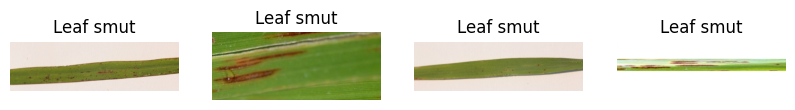

Bacterial leaf blight:


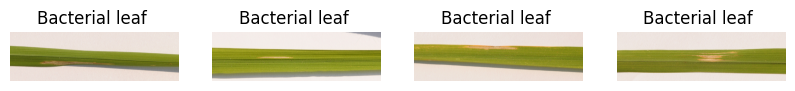

Brown spot:


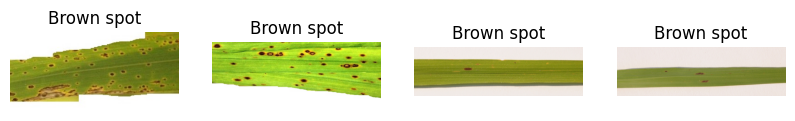

In [95]:
print("Sample images per class \n")
for cls in os.listdir(base_dir):
    print(f"{cls}:")
    show_samples(cls)


Data Generators

In [96]:
IMG_SIZE = (224, 224)
BATCH_SIZE = 8

train_dir = os.path.join(output_dir, "train")
val_dir   = os.path.join(output_dir, "val")
test_dir  = os.path.join(output_dir, "test")


No augmentation

In [97]:
train_datagen_no_aug = ImageDataGenerator(
    rescale=1./255
)
#nueral networks works best with smaller pixel that is between 0 - 1 so all the images are rescaled into that particular range

with Augmentation

In [98]:
train_datagen_aug = ImageDataGenerator(
    rescale=1./255,
    horizontal_flip=True,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1
)


for validation

In [99]:
val_test_datagen = ImageDataGenerator(
    rescale=1./255
)
#no augment
train_gen_no_aug = train_datagen_no_aug.flow_from_directory(
    train_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical"
)
#augment
train_gen_aug = train_datagen_aug.flow_from_directory(
    train_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical"
)

Found 83 images belonging to 3 classes.
Found 83 images belonging to 3 classes.


In [100]:
val_gen = val_test_datagen.flow_from_directory(
    val_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    shuffle=False
)


Found 17 images belonging to 3 classes.


In [101]:
test_gen = val_test_datagen.flow_from_directory(
    test_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    shuffle=False
)


Found 19 images belonging to 3 classes.


In [102]:
print("Train subfolders:", os.listdir(train_dir))
print("Val subfolders  :", os.listdir(val_dir))
print("Test subfolders :", os.listdir(test_dir))


Train subfolders: ['Brown spot', 'Bacterial leaf blight', 'Leaf smut']
Val subfolders  : ['Brown spot', 'Bacterial leaf blight', 'Leaf smut']
Test subfolders : ['Brown spot', 'Bacterial leaf blight', 'Leaf smut']


Defining the model


creating CNN


In [104]:
num_classes = 3
#creating CNN
def create_baseline_cnn():
    model = models.Sequential([
        layers.Input(shape=(*IMG_SIZE, 3)),

        layers.Conv2D(32, (3,3), activation="relu"),
        layers.MaxPooling2D((2,2)),

        layers.Conv2D(64, (3,3), activation="relu"),
        layers.MaxPooling2D((2,2)),

        layers.Conv2D(128, (3,3), activation="relu"),
        layers.MaxPooling2D((2,2)),

        layers.Flatten(),
        layers.Dropout(0.5),
        layers.Dense(128, activation="relu"),
        layers.Dense(num_classes, activation="softmax")
    ])



    model.compile(
        optimizer=tf.keras.optimizers.Adam(1e-3),
        loss="categorical_crossentropy",
        metrics=["accuracy"]
    )
    return model


MobileNetV2 model

In [105]:
def create_mobilenet_model():
    base_model = applications.MobileNetV2(
        weights="imagenet",
        include_top=False,
        input_shape=(*IMG_SIZE, 3)
    )
    base_model.trainable = False  # freeze base initially


    inputs = layers.Input(shape=(*IMG_SIZE, 3))
    x = base_model(inputs, training=False)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(0.4)(x)
    outputs = layers.Dense(num_classes, activation="softmax")(x)
    model = models.Model(inputs, outputs)

    model.compile(
        optimizer=tf.keras.optimizers.Adam(1e-3),
        loss="categorical_crossentropy",
        metrics=["accuracy"]
    )
    return model


TRAINING UTILS


In [106]:
early_stop = tf.keras.callbacks.EarlyStopping(
    patience=5,
    restore_best_weights=True,
    monitor="val_accuracy"
)


In [107]:
def plot_history(h, title_prefix=""):
    acc = h.history['accuracy']
    val_acc = h.history['val_accuracy']
    loss = h.history['loss']
    val_loss = h.history['val_loss']
    epochs = range(1, len(acc) + 1)


    plt.figure(figsize=(12,4))

    # Accuracy
    plt.subplot(1,2,1)
    plt.plot(epochs, acc, label='Train Acc')
    plt.plot(epochs, val_acc, label='Val Acc')
    plt.title(title_prefix + "Accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()
    # Loss
    plt.subplot(1,2,2)
    plt.plot(epochs, loss, label='Train Loss')
    plt.plot(epochs, val_loss, label='Val Loss')
    plt.title(title_prefix + "Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()

    plt.show()


Model 1 - Cnn(With augmentation)

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/25
11/11 ━━━━━━━━━━━━━━━━━━━━ 17s 1s/step - accuracy: 0.2013 - loss: 3.1148 - val_accuracy: 0.3529 - val_loss: 1.1407
Epoch 2/25
11/11 ━━━━━━━━━━━━━━━━━━━━ 14s 1s/step - accuracy: 0.3010 - loss: 1.1380 - val_accuracy: 0.2941 - val_loss: 1.0972
Epoch 3/25
11/11 ━━━━━━━━━━━━━━━━━━━━ 14s 1s/step - accuracy: 0.3618 - loss: 1.1023 - val_accuracy: 0.2941 - val_loss: 1.0909
Epoch 4/25
11/11 ━━━━━━━━━━━━━━━━━━━━ 14s 1s/step - accuracy: 0.2494 - loss: 1.0997 - val_accuracy: 0.4118 - val_loss: 1.0569
Epoch 5/25
11/11 ━━━━━━━━━━━━━━━━━━━━ 14s 1s/step - accuracy: 0.4088 - loss: 1.0651 - val_accuracy: 0.4118 - val_loss: 1.0598
Epoch 6/25
11/11 ━━━━━━━━━━━━━━━━━━━━ 13s 1s/step - accuracy: 0.5370 - loss: 1.0619 - val_accuracy: 0.3529 - val_loss: 1.0556
Epoch 7/25
11/11 ━━━━━━━━━━━━━━━━━━━━ 14s 1s/step - accuracy: 0.5086 - loss: 1.0110 - val_accuracy: 0.3529 - val_loss: 1.0006
Epoch 8/25
11/11 ━━━━━━━━━━━━━━━━━━━━ 14s 1s/step - accuracy: 0.4797 - loss: 0.9729 - val_accuracy: 0.5294 - val_loss:

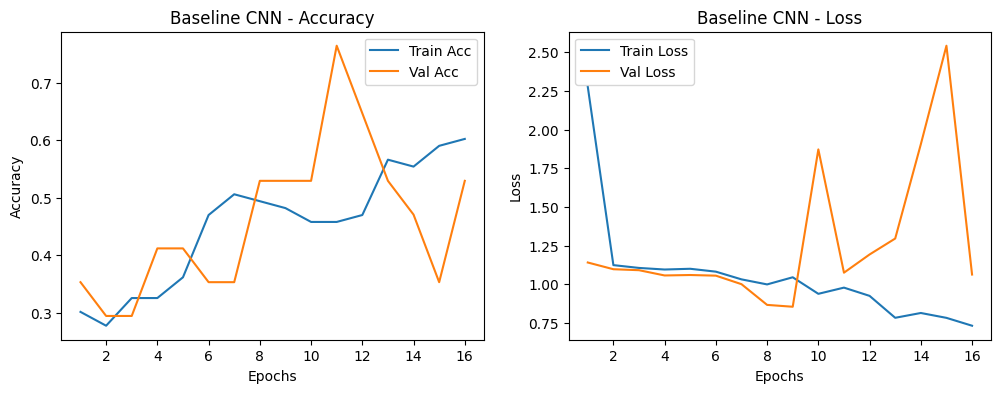

Evaluating Baseline CNN on test set...
Test Accuracy (Baseline CNN): 0.7894737124443054


In [108]:
baseline_cnn = create_baseline_cnn()
history_cnn = baseline_cnn.fit(
    train_gen_aug,
    epochs=25,
    validation_data=val_gen,
    callbacks=[early_stop],
    verbose=1
)
plot_history(history_cnn, "Baseline CNN - ")

print("Evaluating Baseline CNN on test set...")
test_loss_cnn, test_acc_cnn = baseline_cnn.evaluate(test_gen, verbose=0)
print("Test Accuracy (Baseline CNN):", test_acc_cnn)


MODEL 2 – MobileNetV2 with and without augmentation

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/25
11/11 ━━━━━━━━━━━━━━━━━━━━ 14s 621ms/step - accuracy: 0.4728 - loss: 1.3105 - val_accuracy: 0.3529 - val_loss: 1.1896
Epoch 2/25
11/11 ━━━━━━━━━━━━━━━━━━━━ 6s 524ms/step - accuracy: 0.5321 - loss: 0.9849 - val_accuracy: 0.6471 - val_loss: 0.9232
Epoch 3/25
11/11 ━━━━━━━━━━━━━━━━━━━━ 4s 393ms/step - accuracy: 0.5618 - loss: 0.8331 - val_accuracy: 0.7059 - val_loss: 0.7644
Epoch 4/25
11/11 ━━━━━━━━━━━━━━━━━━━━ 5s 453ms/step - accuracy: 0.8085 - loss: 0.6047 - val_accuracy: 0.6471 - val_loss: 0.7157
Epoch 5/25
11/11 ━━━━━━━━━━━━━━━━━━━━ 6s 481ms/step - accuracy: 0.7827 - loss: 0.5070 - val_accuracy: 0.8235 - val_loss: 0.6641
Epoch 6/25
11/11 ━━━━━━━━━━━━━━━━━━━━ 4s 397ms/step - accuracy: 0.8420 - loss: 0.4504 - val_accuracy: 0.8235 - val_loss: 0.6014
Epoch 7/25
11/11 ━━━━━━━━━━━━━━━━━━━━ 5s 496ms/step - accuracy: 0.8494 - loss: 0.3606 - val_accuracy: 0.8235 - val_loss: 0.6107
Epoch 8/25
11/11 ━━━━━━━━━━━━━━━━━━━━ 5s 433ms/step - 

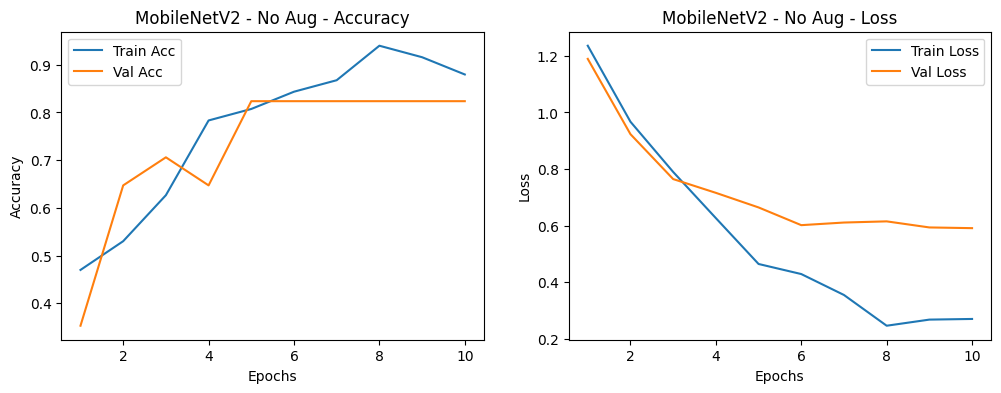

Evaluating MobileNetV2 (No Aug) on test set...
Test Accuracy (MobileNetV2 - No Aug): 0.7894737124443054


In [109]:
#no augmentation
model_mnet_no_aug = create_mobilenet_model()
history_mnet_no_aug = model_mnet_no_aug.fit(
    train_gen_no_aug,
    epochs=25,
    validation_data=val_gen,
    callbacks=[early_stop],
    verbose=1
)
plot_history(history_mnet_no_aug, "MobileNetV2 - No Aug - ")

print("Evaluating MobileNetV2 (No Aug) on test set...")
test_loss_mnet_A, test_acc_mnet_A = model_mnet_no_aug.evaluate(test_gen, verbose=0)
print("Test Accuracy (MobileNetV2 - No Aug):", test_acc_mnet_A)



Epoch 1/25
11/11 ━━━━━━━━━━━━━━━━━━━━ 14s 735ms/step - accuracy: 0.3967 - loss: 1.4570 - val_accuracy: 0.3529 - val_loss: 0.9823
Epoch 2/25
11/11 ━━━━━━━━━━━━━━━━━━━━ 8s 690ms/step - accuracy: 0.4231 - loss: 1.1993 - val_accuracy: 0.5882 - val_loss: 0.8402
Epoch 3/25
11/11 ━━━━━━━━━━━━━━━━━━━━ 5s 471ms/step - accuracy: 0.5870 - loss: 0.9632 - val_accuracy: 0.7647 - val_loss: 0.6468
Epoch 4/25
11/11 ━━━━━━━━━━━━━━━━━━━━ 6s 518ms/step - accuracy: 0.6809 - loss: 0.8132 - val_accuracy: 0.8235 - val_loss: 0.6238
Epoch 5/25
11/11 ━━━━━━━━━━━━━━━━━━━━ 7s 559ms/step - accuracy: 0.6584 - loss: 0.7844 - val_accuracy: 0.7647 - val_loss: 0.6089
Epoch 6/25
11/11 ━━━━━━━━━━━━━━━━━━━━ 5s 459ms/step - accuracy: 0.6842 - loss: 0.7500 - val_accuracy: 0.8235 - val_loss: 0.5978
Epoch 7/25
11/11 ━━━━━━━━━━━━━━━━━━━━ 7s 649ms/step - accuracy: 0.8753 - loss: 0.4412 - val_accuracy: 0.7647 - val_loss: 0.5606
Epoch 8/25
11/11 ━━━━━━━━━━━━━━━━━━━━ 5s 473ms/step - accuracy: 0.7476 - loss: 0.5484 - val_accuracy: 0

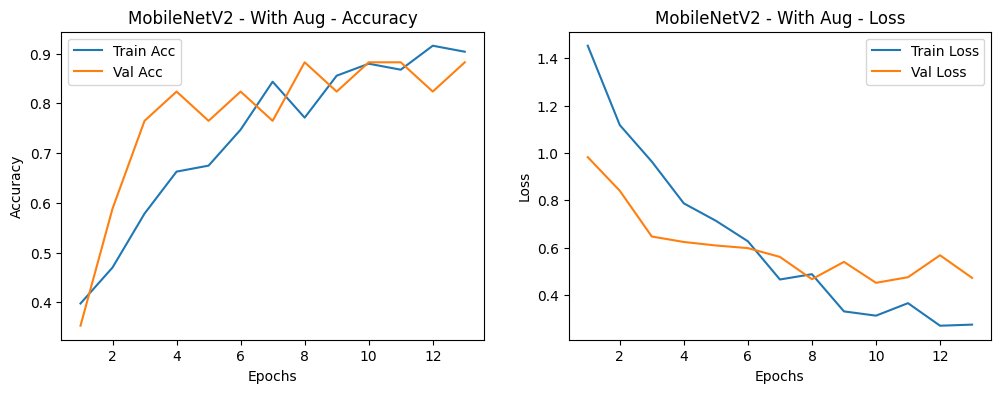

Evaluating MobileNetV2 (With Aug) on test set...
Test Accuracy (MobileNetV2 - With Aug): 0.8947368264198303


In [111]:
#with augmentation
model_mnet_aug = create_mobilenet_model()

history_mnet_aug = model_mnet_aug.fit(
    train_gen_aug,
    epochs=25,
    validation_data=val_gen,
    callbacks=[early_stop],
    verbose=1
)

plot_history(history_mnet_aug, "MobileNetV2 - With Aug - ")

print("Evaluating MobileNetV2 (With Aug) on test set...")
test_loss_mnet_B, test_acc_mnet_B = model_mnet_aug.evaluate(test_gen, verbose=0)
print("Test Accuracy (MobileNetV2 - With Aug):", test_acc_mnet_B)


fine tuning mobileNet v2

Epoch 1/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 19s 892ms/step - accuracy: 0.7421 - loss: 0.6965 - val_accuracy: 0.8235 - val_loss: 0.4596
Epoch 2/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 6s 595ms/step - accuracy: 0.5894 - loss: 0.8661 - val_accuracy: 0.8235 - val_loss: 0.4515
Epoch 3/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 9s 828ms/step - accuracy: 0.6694 - loss: 0.7277 - val_accuracy: 0.8235 - val_loss: 0.4408
Epoch 4/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 6s 540ms/step - accuracy: 0.7343 - loss: 0.7140 - val_accuracy: 0.8235 - val_loss: 0.4314
Epoch 5/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 9s 788ms/step - accuracy: 0.8334 - loss: 0.4948 - val_accuracy: 0.8235 - val_loss: 0.4164
Epoch 6/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 7s 617ms/step - accuracy: 0.6716 - loss: 0.6612 - val_accuracy: 0.8235 - val_loss: 0.4056


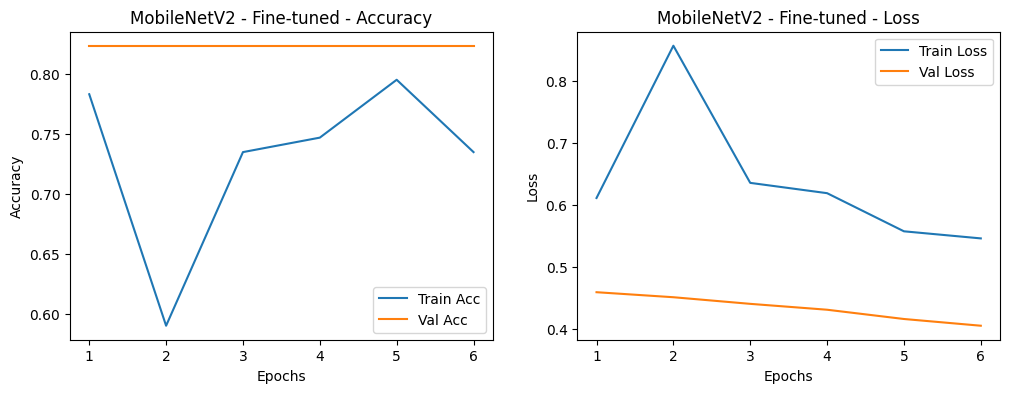

Evaluating fine-tuned MobileNetV2 on test set...
Test Accuracy (MobileNetV2 - Fine-tuned): 0.8947368264198303


In [112]:

base_model = model_mnet_aug.layers[1]   # MobileNetV2 is the 2nd layer
base_model.trainable = True

# Freeze most layers, unfreeze last 20
for layer in base_model.layers[:-20]:
    layer.trainable = False

# Re-compile with very small learning rate for fine-tuning
model_mnet_aug.compile(
    optimizer=tf.keras.optimizers.Adam(1e-5),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

history_mnet_ft = model_mnet_aug.fit(
    train_gen_aug,
    epochs=10,
    validation_data=val_gen,
    callbacks=[early_stop],
    verbose=1
)

plot_history(history_mnet_ft, "MobileNetV2 - Fine-tuned - ")

print("Evaluating fine-tuned MobileNetV2 on test set...")
test_loss_mnet_FT, test_acc_mnet_FT = model_mnet_aug.evaluate(test_gen, verbose=0)
print("Test Accuracy (MobileNetV2 - Fine-tuned):", test_acc_mnet_FT)

Final evaluation


3/3 ━━━━━━━━━━━━━━━━━━━━ 6s 1s/step
Confusion Matrix:
 [[6 0 0]
 [0 6 0]
 [2 0 5]]

Classification Report:

                       precision    recall  f1-score   support

Bacterial leaf blight       0.75      1.00      0.86         6
           Brown spot       1.00      1.00      1.00         6
            Leaf smut       1.00      0.71      0.83         7

             accuracy                           0.89        19
            macro avg       0.92      0.90      0.90        19
         weighted avg       0.92      0.89      0.89        19



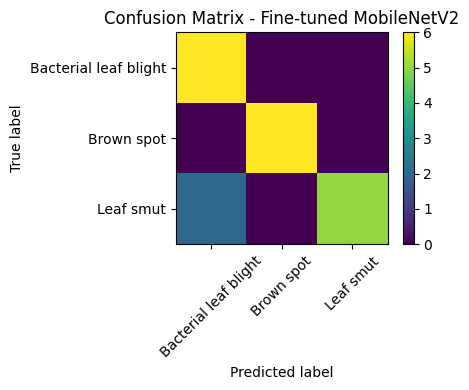

In [113]:
test_gen.reset()
y_true = test_gen.classes
y_prob = model_mnet_aug.predict(test_gen)
y_pred = np.argmax(y_prob, axis=1)
cm = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:\n", cm)
class_labels = list(test_gen.class_indices.keys())
print("\nClassification Report:\n")
print(classification_report(y_true, y_pred, target_names=class_labels))
plt.figure(figsize=(5,4))
plt.imshow(cm, interpolation='nearest')
plt.title("Confusion Matrix - Fine-tuned MobileNetV2")
plt.colorbar()
tick_marks = np.arange(len(class_labels))
plt.xticks(tick_marks, class_labels, rotation=45)
plt.yticks(tick_marks, class_labels)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.tight_layout()
plt.show()


Model comparison Summary


In [114]:
print("\n\n=== MODEL COMPARISON SUMMARY (Test Accuracy) ===")
print(f"Baseline CNN (With Aug)            : {test_acc_cnn:.4f}")
print(f"MobileNetV2 (No Aug)               : {test_acc_mnet_A:.4f}")
print(f"MobileNetV2 (With Aug)             : {test_acc_mnet_B:.4f}")
print(f"MobileNetV2 (With Aug + Fine-tune) : {test_acc_mnet_FT:.4f}")




=== MODEL COMPARISON SUMMARY (Test Accuracy) ===
Baseline CNN (With Aug)            : 0.7895
MobileNetV2 (No Aug)               : 0.7895
MobileNetV2 (With Aug)             : 0.8947
MobileNetV2 (With Aug + Fine-tune) : 0.8947
